In [1]:
from binance.client import Client
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime

api_key = "bGCPhL3K9wXUvfS39UbFiJ6QQcyewSDv6vlPdEXUZCs5r4UtXtdTNuuLbxpZKvjA"
api_secret = "B13kTHX3iwUb0Davkwz8Q6vres0XAgeYmdm7aHa9nEeWmdNvzdqN0hv8TjRn0K66"
client = Client(api_key, api_secret)

In [2]:
## Raw data
# agg_trades = client.aggregate_trade_iter(symbol='ETCUSDT', start_str='60 minutes ago UTC')

# # iterate over the trade iterator
# df_dict = {'a':[], 'p':[], 'q':[], 'f':[], 'l':[],'T':[], 'm':[],'M':[]}
# for trade in agg_trades:
#     # prices.append(trade["p"])
#     df_dict['a'].append(trade["a"])
#     df_dict['p'].append(trade["p"])
#     df_dict['q'].append(trade["q"])
#     df_dict['f'].append(trade["f"])
#     df_dict['l'].append(trade["l"])
#     df_dict['T'].append(trade["T"])
#     df_dict['m'].append(trade["m"])
#     df_dict['M'].append(trade["M"])
#     print(trade)

# df = pd.DataFrame.from_dict(df_dict)
# interested_df = df[['p','q','T']]  # get price as p, quantity as q, Time as T

In [3]:
avg_data = client.get_klines(symbol='ETCUSDT', interval=Client.KLINE_INTERVAL_30MINUTE)
cols = ['open_time',  # Open time
            'open',  # Open
            'high',  # High
            'low',  # Low
            'close',  # Close
            'vol',  # Volume
            'close_time',  # Close time
            'quote_ass_vol',  # Quote asset volume
            'no_trade',  # Number of trades
            'base_ass_vol',  # Taker buy base asset volume
            'qoute_ass_vol',  # Taker buy quote asset volume
            'ignore']   # Can be ignored
df = pd.DataFrame(avg_data, 
    columns = cols)

important_features_df = df[['close','close_time','vol']]  # get important features
important_features_df.close_time = important_features_df.close_time.apply(lambda x: x/1000)  # convert milisecond to second
# important_features_df.close_time = important_features_df.close_time.apply(lambda x: datetime.fromtimestamp(x/1000))  # convert to normal time format

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [4]:
date_time = important_features_df.pop('close_time')  # extract date_time as seconds

In [5]:
important_features_df.describe()  # inspection

,close,vol
count,500,500
unique,497,500
top,119.00000000,137729.57900000
freq,2,1


In [6]:
# convert time data to vector as it is better for model

day = 24*60*60
year = (365.2425)*day

important_features_df['Day sin'] = np.sin(date_time * (2 * np.pi / day))
important_features_df['Day cos'] = np.cos(date_time * (2 * np.pi / day))
important_features_df['Year sin'] = np.sin(date_time * (2 * np.pi / year))
important_features_df['Year cos'] = np.cos(date_time * (2 * np.pi / year))

ipykernel_launcher:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be

In [7]:
important_features_df.close = important_features_df.close.astype(float)  # make sure close is float
important_features_df.vol = important_features_df.vol.astype(float)  # make sure vol is float

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 1.0, 'Time of day signal')

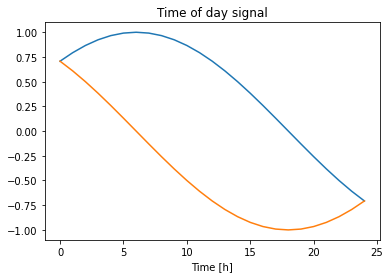

In [8]:
plt.plot(np.array(important_features_df['Day sin'])[:25])
plt.plot(np.array(important_features_df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [9]:
# data splitting
# column_indices = {name: i for i, name in enumerate(important_features_df.columns)}

n = len(important_features_df)
train_df = important_features_df[0:int(n*0.7)]  # 70% train data
val_df = important_features_df[int(n*0.7):int(n*0.9)]  # 20% val data
test_df = important_features_df[int(n*0.9):]  # 10% test data

num_features = important_features_df.shape[1]

In [10]:
# normalization
train_mean = train_df.mean()
train_std = train_df.std()

# make sure train data as main distribution
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


In [29]:
time_predictors = 24  # number of historical data as predictor
time_shift = 24  # number of timestamp to target
label_width = 1  # number of predicting timestamp

class WindowGenerator():
    """
    This class make indices base on inputs
    """
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)  # make slice for input
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]  # get indexes of time features

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)  # make slice for label from start
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]  # get indexes of time features

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def window_maker(self, data_matrix):
        """
        Make window function
        This function extract timestamp as features.
        It also extract timestamp as labels
        Args:

        Output:
            inputs: index of features in input matrix
            labels: index of label in input matrix
        """
        inputs = data_matrix[:, self.input_slice, :]  # extract inputs data using indexes
        labels = data_matrix[:, self.labels_slice, :]  # extract labels data using indexes
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)
        
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='close', max_subplots=3):
        """
        Plot function
        """
        inputs, labels = self.example
        print("len of input", len(inputs))
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        """
        convert dataframe to matrix of shape (batch, time features, static features)
        Input:
            dataframe
        Output:
            tensordata
        """
        data = np.array(data, dtype=np.float32)
        
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)  # hardcore batchsize, need to change later

        ds = ds.map(self.window_maker)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [12]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [13]:
# make batch
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.window_maker(example_window)  # divide into input and label by batch

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
labels shape: (3, 1, 1)


In [14]:
train_df[:w2.total_window_size]

,close,vol,Day sin,Day cos,Year sin,Year cos
0,-1.083667,-0.636972,0.941034,1.012445,1.667619,1.747034
1,-1.088005,-0.776803,1.061715,0.872083,1.658717,1.736772
2,-1.089479,-0.836164,1.163402,0.716854,1.649810,1.726513
3,-1.091776,-0.838336,1.244355,0.549416,1.640896,1.716255
4,-1.094924,-0.801244,1.303189,0.372632,1.631977,1.706000
5,-1.074706,-0.730472,1.338897,0.189527,1.623052,1.695746
6,-1.083071,-0.812015,1.350868,0.003235,1.614122,1.685495


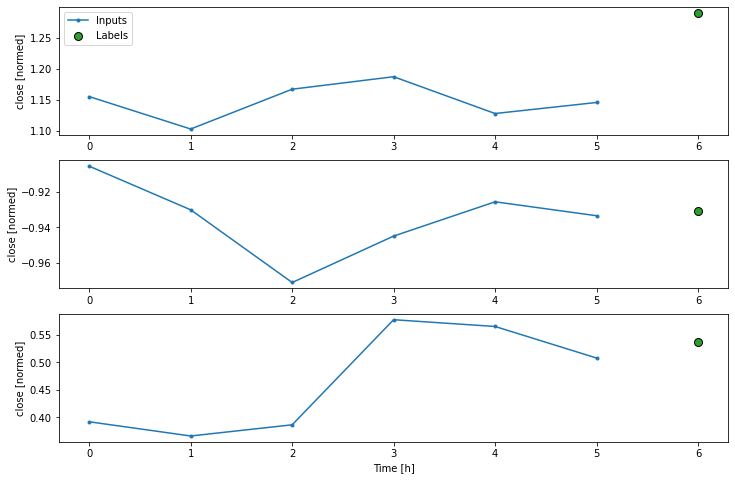

In [16]:
w2.plot(plot_col='close')

In [21]:
# prepare data
single_step_window = WindowGenerator(
    input_width=24, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['close'])
single_step_window

# model
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [30]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

In [31]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


len of input 32


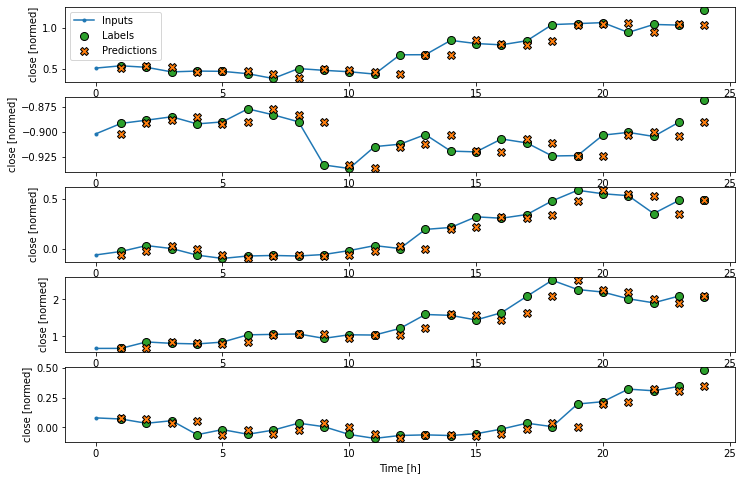

In [32]:
wide_window.plot(baseline, max_subplots=5)

In [59]:
# main model
linear = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    # tf.keras.layers.Reshape([1, -1]),
])

# training setting

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [60]:
history = compile_and_fit(linear, single_step_window)
# linear.summary()
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 0s 11ms/step - loss: 0.6359 - mean_absolute_error: 0.6828 - val_loss: 0.1205 - val_mean_absolute_error: 0.3014
Epoch 2/20
11/11 [==============================] - 0s 6ms/step - loss: 0.1700 - mean_absolute_error: 0.3004 - val_loss: 0.2363 - val_mean_absolute_error: 0.4462
Epoch 3/20
3/3 [==============================] - 0s 667us/step - loss: 0.4784 - mean_absolute_error: 0.6499


len of input 32


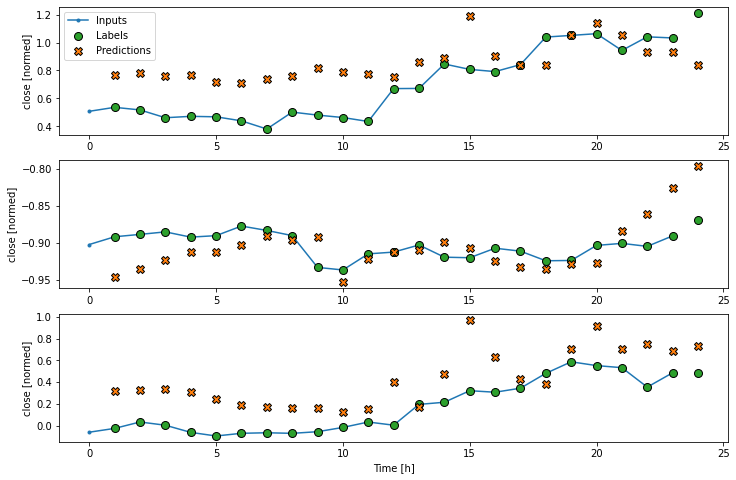

In [61]:
wide_window.plot(linear)

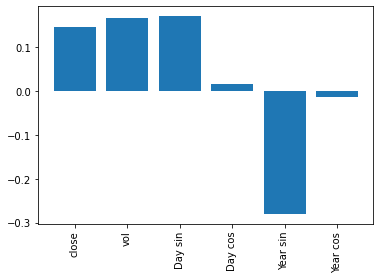

In [63]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [64]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)
